>a) Cargue los datos a analizar, descargándolos desde la plataforma como se indicó, en formato dataframe pandas. Descríbalos adecuadamente, ya sea la variable dependiente o las independientes, si es que lo son.

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv("timesData.csv")
print(df.shape)

(2603, 14)


>b) Debido a la estructura será necesario realizar un leve pre-proceso. Existen vacíos entre los datos o valores '-', por lo que será necesario eliminarlos (o si piensa una mejor manera de manejar ésto puede hacerlo, se verá reflejado en su nota). Además de ésto deje los datos con score unkown o '-' en un conjunto target separado, unlabeled data (éste será el objetivo del entrenamiento) ¿Cuántos datos quedan en cada conjunto?

In [4]:
def convertToInt(x):
    try:
        x = int(x)
    except:
        x = 0
    return x
df.dropna(axis=0,inplace=True,how='any') #borra nan
print(df.shape)

(2362, 14)


In [5]:
df["total_score"] = df["total_score"].apply(lambda x: x.replace('-','unknown')) #rellena
df = df[~(df == '-').any(axis=1)] #elimina filas con valores nulos
print(df.shape)

(2174, 14)


In [6]:
nuevo_df  = pd.get_dummies(df, columns=["country"]) #column to categorical
nuevo_df['female'] = nuevo_df['female_male_ratio'].str.split(':', expand=True)[0].apply(convertToInt)
nuevo_df['male'] = nuevo_df['female_male_ratio'].str.split(':', expand=True)[1].apply(convertToInt)
nuevo_df['female_male_ratio'] =  np.where(nuevo_df['male'] == 0, 0, nuevo_df['female']/nuevo_df['male']) #si no hay (rellena 0) 
nuevo_df['num_students'] = nuevo_df['num_students'].apply(lambda x: int(str(x).replace(',','')))
nuevo_df['international_students'] = nuevo_df['international_students'].apply(lambda x: int(str(x).replace('%','')))
print(nuevo_df.shape)
df_test = nuevo_df[nuevo_df["total_score"]=='unknown']  #para predecir al final
nuevo_df =  nuevo_df[nuevo_df["total_score"]!='unknown'] #elimina unknown rank..
print(nuevo_df.shape)
nuevo_df.head(5)

(2174, 82)
(954, 82)


,world_rank,university_name,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,...,country_Taiwan,country_Thailand,country_Turkey,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States of America,female,male
1,2,California Institute of Technology,97.7,54.6,98.0,99.9,83.7,96.0,2243,6.9,...,0,0,0,0,0,0,0,1,33,67
2,3,Massachusetts Institute of Technology,97.8,82.3,91.4,99.9,87.5,95.6,11074,9.0,...,0,0,0,0,0,0,0,1,37,63
3,4,Stanford University,98.3,29.5,98.1,99.2,64.3,94.3,15596,7.8,...,0,0,0,0,0,0,0,1,42,58
5,6,University of Cambridge,90.5,77.7,94.1,94.0,57.0,91.2,18812,11.8,...,0,0,0,0,0,0,1,0,46,54
6,6,University of Oxford,88.2,77.2,93.9,95.1,73.5,91.2,19919,11.6,...,0,0,0,0,0,0,1,0,46,54


En el conjunto con el que trabajaremos quedaron 954 datos, mientras que enel conjunto con datos sin especificar quedaron 2174 datos.

>c) Cree las matrices de cada conjunto con las que trabajará. Además de ésto separe el conjunto de pruebas fijo que se utilizará, recuerde que éste no puede ser utilizado. Si estima conveniente también cree conjunto de validación.

In [7]:
Y = nuevo_df['total_score'].values
X = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).values
X_test = df_test.drop(["total_score","world_rank","university_name"],axis=1).values

Y = Y.astype('float32')
X = X.astype('float32')
X_test = X_test.astype('float32')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape

(533, 79)

>d) Normalice los datos antes de trabajar. Explique la importancia/conveniencia de realizar ésto.

Este paso es de vital por una serie de razones, primero esta la ineficiencia que se genera en las operaciones al no normalizar, segundo los datos estan mejor organizados, entre otras.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

>e) Realice una regresión lineal de mı́nimos cuadrados básica. Mida el residuo de cada predicción en cada dato y haga un gráfico de éste ¿Qué indica lo observado?

In [9]:
from sklearn.linear_model import LinearRegression as LR
linreg = LR(fit_intercept=True, n_jobs=1)
linreg.fit(X_train_scaled,y_train)

import seaborn as sns
res = y_train-linreg.predict(X_train_scaled)
sns.distplot(res)

/home/maldos/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Este error se produce porque el paquete seaborn  de conda no tiene este parche.

>f) Construya una tabla con los pesos, Z-score y F-score correspondientes a cada predictor (variable), compare estos valores. ¿Qué sucede si hacemos un raking de los atributos en base al peso obtenido en la regresión? Compare y comente ¿Qué variables están más correlacionadas con la respuesta? Si usáramos un nivel de significación del 5%. ¿Qué es lo que observa y cuál puede ser la causa?

In [10]:
from scipy import stats
from sklearn.metrics import f1_score

promediosColumnas = list()
for i in range(79):
    sumaColumna=0
    for j in range (533):
        sumaColumna+=X_train[j][i]
    promediosColumnas.append(sumaColumna/533.0)
    
# stats.zscore(promediosColumnas)
f1_score(Y,X)

ValueError: Classification metrics can't handle a mix of continuous and continuous-multioutput targets

In [ ]:
print "ZSCORE  \t\t| FSCORE" 
for i in range(79):
    print str(stats.zscore(promediosColumnas)[i]) + " \t| " + str(i+3) 

>g) Calcule la información mútua de los distintos predictores (variables) con respecto a la variable output o target. Comente con lo calculado anteriormente y se le parece razonable.

/home/maldos/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


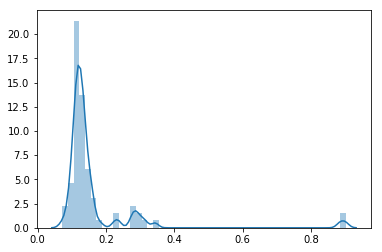

In [13]:
from sklearn.feature_selection import mutual_info_regression
minfo_predictor = mutual_info_regression(X,Y)

sns.distplot(minfo_predictor)
#Se produce el mismo warning que en el gráfico de la pregunta "e"

A partir del gráfico se pueden ver aproximadamente 6 puntos de valores(X.columnas) que influyen de manera significativa en los valores target(Y).

Cabe destacar que el warning que aparece en el gráfico es por la misma razon que  la pregunta "e".

In [14]:
ind = np.argpartition(np.array(minfo_predictor), -6)[-6:]
print ind
names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
for i in range (6):
    print names_regressors[ind[5-i]]

[77  8  3  2  7  0]
teaching
international_students
research
citations
female_male_ratio
female


A partir de la cantidad de puntos que influyen a target. se buscan los nombres de las columnas a las que corresponden dichos puntos. Se pudo encontrar que las variables que más influyen a Y son:

    -teaching
    
    -international_students

    -research

    -citations

    -female_male_ratio

    -female
    
Estos valores si tienen sentido que sean los mas importantes, teaching es obviamente un factor importante sobre una universidad, international students habla sobre el interes de los alumnos de otras universidades en esto, reasearch y citacion estan fuertemente ligadas y hablan sobre la calidad de una universidad en el ámbito de la investigación, el cual es de vital importancia en una universidad y por último esta female_male_ratio y female, lo que nos podria decir que esta en una sociedad mas "progresista", lo que en general va de la mano con una sociedad mas "evolucionada. 

>h) Construya una función que implemente Forward Step-wise Selection (FSS). Es decir, partiendo con un modelo sin predictores (variables), agregue un predictor a la vez, re-ajustando el modelo de regresión en cada paso. Para seleccionar localmente una variable, proponga/implemente un criterio distinto al utilizado en el código de ejemplo. Construya un gráfico que muestre el error de entrenamiento y el error de pruebas como función del número de variables en el modelo. Ordene el eje  𝑥  de menor a mayor.

In [15]:
from sklearn.linear_model import LinearRegression as LR
def fss(x, y, names_x, k = 10000):
    p = x.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = range(0, p)
    selected = [p]
    current_score = best_new_score = 0.0
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            model = LR(fit_intercept=True, n_jobs=1)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            predictions_train = model.fit(x_train, y).predict(x_train)
            residuals_train = predictions_train - y
            mse_candidate = np.mean(np.power(residuals_train, 2))
            score_candidates.append((mse_candidate, candidate))
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop()
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print "selected = %s ..."%names_x[best_candidate]
        print "totalvars=%d, mse = %f"%(len(indexes),best_new_score)
    return selected
names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
fss(X_train_scaled,y_train,names_regressors)

selected = teaching ...
totalvars=2, mse = 26.549631
selected = citations ...
totalvars=3, mse = 9.827469
selected = research ...
totalvars=4, mse = 2.431706
selected = international ...
totalvars=5, mse = 0.314906
selected = income ...
totalvars=6, mse = 0.075387
selected = country_Egypt ...
totalvars=7, mse = 0.069453
selected = year ...
totalvars=8, mse = 0.065400
selected = country_United States of America ...
totalvars=9, mse = 0.062808
selected = international_students ...
totalvars=10, mse = 0.062021
selected = country_New Zealand ...
totalvars=11, mse = 0.061665
selected = country_Turkey ...
totalvars=12, mse = 0.061379
selected = num_students ...
totalvars=13, mse = 0.061113
selected = country_Singapore ...
totalvars=14, mse = 0.060909
selected = country_Italy ...
totalvars=15, mse = 0.060727
selected = country_Japan ...
totalvars=16, mse = 0.060519
selected = country_Australia ...
totalvars=17, mse = 0.060415
selected = country_Denmark ...
totalvars=18, mse = 0.060299
selecte

[78,
 0,
 3,
 2,
 1,
 4,
 23,
 9,
 76,
 7,
 48,
 71,
 5,
 61,
 36,
 37,
 11,
 22,
 16,
 26,
 18,
 66,
 64,
 69,
 42,
 8,
 75,
 29,
 50,
 65,
 56,
 68,
 47,
 6,
 35,
 25,
 15,
 27,
 77,
 12,
 67,
 10,
 13,
 17,
 19,
 14,
 20,
 21,
 24,
 28,
 30,
 31,
 32,
 33,
 34,
 38,
 39,
 40,
 41,
 43,
 44,
 45,
 46,
 49,
 51,
 52,
 53,
 54,
 55,
 57,
 58,
 59,
 60,
 62,
 63,
 70,
 72,
 73,
 74]

In [16]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error

def fss(x, y, names_x, k = 10000):
    p = x.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = range(0, p)
    selected = [p]
    current_score = best_new_score = 0.0
    while remaining and len(selected)<=k :
        score_candidates = []
        for candidate in remaining:
            model = LR(fit_intercept=True, n_jobs=1)
            indexes = selected + [candidate]
            x_train = x[:,indexes]
            predictions_train = model.fit(x_train, y).predict(x_train)
            mae_candidate = mean_absolute_error(y, predictions_train)
            score_candidates.append((mae_candidate, candidate))
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop()
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print "selected = %s ..."%names_x[best_candidate]
        print "totalvars=%d, mae = %f"%(len(indexes),best_new_score)
    return selected
names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
fss(X_train_scaled,y_train,names_regressors)

selected = teaching ...
totalvars=2, mae = 4.125315
selected = citations ...
totalvars=3, mae = 2.483279
selected = research ...
totalvars=4, mae = 1.327219
selected = international ...
totalvars=5, mae = 0.440734
selected = income ...
totalvars=6, mae = 0.161774
selected = country_Egypt ...
totalvars=7, mae = 0.153858
selected = international_students ...
totalvars=8, mae = 0.152352
selected = country_Singapore ...
totalvars=9, mae = 0.151367
selected = country_Austria ...
totalvars=10, mae = 0.150685
selected = country_Denmark ...
totalvars=11, mae = 0.150077
selected = country_South Africa ...
totalvars=12, mae = 0.149616
selected = country_Netherlands ...
totalvars=13, mae = 0.149319
selected = country_Canada ...
totalvars=14, mae = 0.148914
selected = country_United Kingdom ...
totalvars=15, mae = 0.148553
selected = country_Australia ...
totalvars=16, mae = 0.148147
selected = country_Norway ...
totalvars=17, mae = 0.147730
selected = female ...
totalvars=18, mae = 0.147347
selec

[78,
 0,
 3,
 2,
 1,
 4,
 23,
 7,
 61,
 12,
 22,
 64,
 47,
 16,
 75,
 11,
 50,
 77,
 29,
 10,
 13,
 17,
 19,
 56,
 15,
 42,
 36,
 71,
 37,
 35,
 18,
 6,
 20,
 48,
 5,
 25,
 27,
 69,
 21,
 24,
 28,
 30,
 31,
 32,
 33,
 34,
 38,
 39,
 8,
 14,
 40,
 41,
 43,
 63,
 65,
 44,
 45,
 46,
 49,
 51,
 52,
 53,
 54,
 55,
 26,
 58,
 57,
 66,
 73,
 70,
 60,
 59,
 62,
 72,
 74,
 67,
 76,
 9,
 68]

>i) Ajuste un modelo lineal utilizando “Ridge Regression”, es decir, regularizando con la norma  𝑙2 . Utilice valores del parámetro de regularización  𝜆  en el rango [$10^0, 10^6$], variando si estima conveniente. Construya un gráfico que muestre los coeficientes obtenidos como función del parámetro de regularización. Deje un gráfico sólo para analizar los coeficientes de los países. Describa lo que observa.

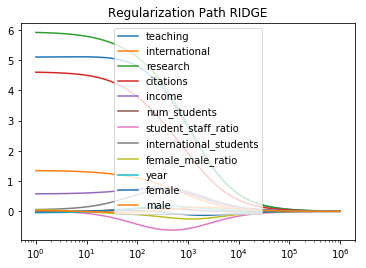

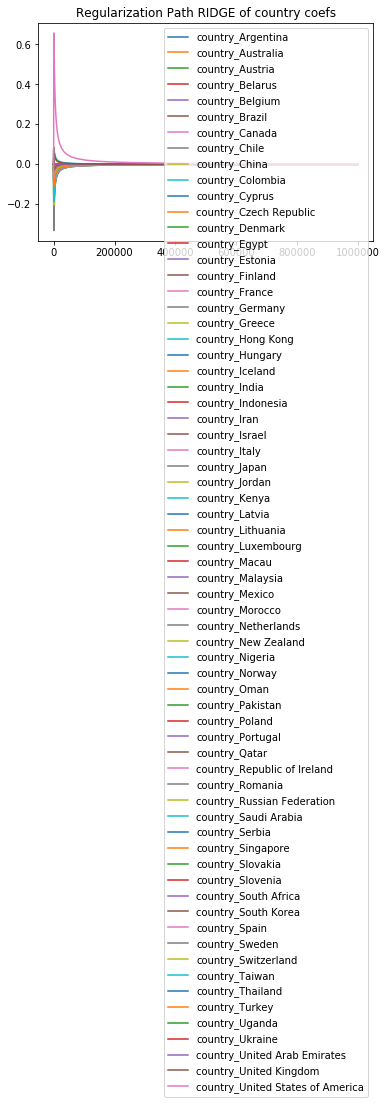

In [17]:
from sklearn.linear_model import Ridge
import matplotlib.pylab as plt
names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
alphas_ = np.logspace(0,6,base=10)
coefs = []
model = Ridge(fit_intercept=True,solver='svd')
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" not in label:
        plt.plot(alphas_, y_arr, label=label)
ax.set_xscale('log')
plt.title('Regularization Path RIDGE')
plt.legend()
plt.show()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" in label:
        plt.plot(alphas_, y_arr, label=label)
plt.title('Regularization Path RIDGE of country coefs')
plt.legend()
plt.show()

Se puede apreciar que el orden que le da a las variables es similar al calculado por los otros metodos y tambien nos podemos dar cuenta que una vez que el regularizador lambda toma valores sobre $10^4$ todas las variables toman un valor casi igual, esto se debe a que el regularizador es ridiculamente grande comparado con los valores.

Sobre el gráfico de los paises podemos darnos cuenta que casi todos tienen igual peso(canada logra destacar un poco y algunos que destacan abajo, pero no se puede identificar bien), esto se debe a que el cambio entre un pais y otro es muy bajo como para pode apreciarlo en este gráfico, por lo cual se recomienda verlo numericamente. Es bueno destacar que a un bajo nivel de lambda toma un valor cercano a cero, esto es porque el regularizador no necesita ser muy grande para que todo sea despreciable. 

>j) Ajuste un modelo lineal utilizando el método “Lasso”, es decir, regularizando con la norma  𝑙1 . Utilice valores del parámetro de regularización  𝜆  en el rango [$10^{-2},10^3$]. Para obtener el código, modifique el ejemplo anterior. Construya un gráfico que muestre los coeficientes obtenidos como función del parámetro de regularización. Describa lo que observa. ¿Es más efectivo Lasso para seleccionar atributos?

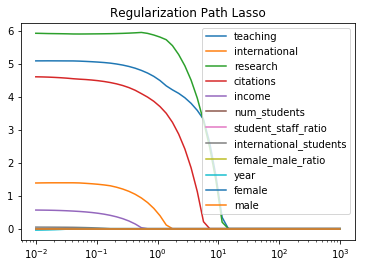

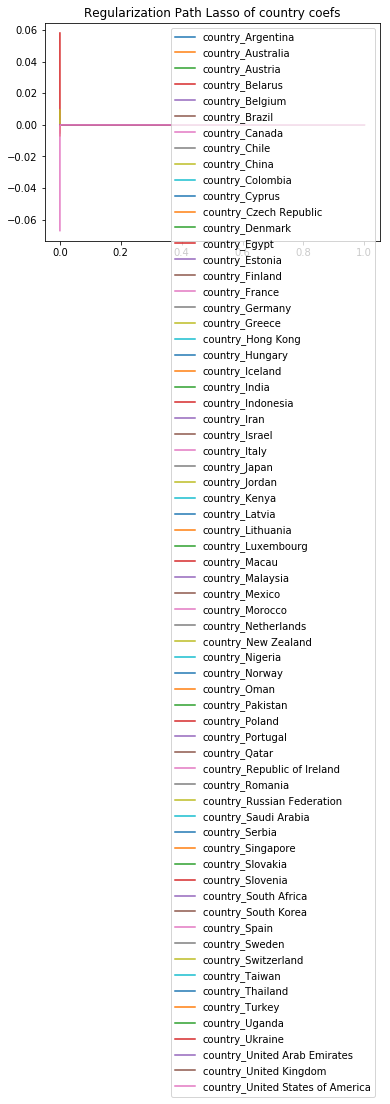

In [18]:
from sklearn.linear_model import Lasso
alphas_ = np.logspace(-2,3,base=10)
country_alphas_ = np.logspace(-5,0,base=10)
coefs = []
model = Lasso(fit_intercept=True)
names_regressors = nuevo_df.drop(["total_score","world_rank","university_name"],axis=1).columns
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)
ax = plt.gca()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" not in label:
        plt.plot(alphas_, y_arr, label=label)
ax.set_xscale('log')
plt.title('Regularization Path Lasso')
plt.legend()
plt.show()
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    if "country" in label:
        plt.plot(country_alphas_, y_arr, label=label)
plt.title('Regularization Path Lasso of country coefs')
plt.legend()
plt.show()

En este caso aplicado, Lasso tiene un mejor comportamiento ya que la gráfica de Lasso es más clara que la que se genera a través de Ridge en el siguiente sentido:
Lasso en función de Lambda puede mostrar claramente cuales son las variables significativas. A medida que lambda crece van desapareciendo una a una la cantidad de variables importantes percibidas. En cambio Ridge tiene un comportamiento "anomalo" en función de labda y a medida que su valor crece, aparecen y luego desaparecen las variables importantes visualizables.

>k) Escogiendo uno de los dos métodos regularizadores anteriores, especificando el porqué, construya un gráfico que muestre el error de entrenamiento y el de pruebas como función del parámetro de regularización. Discuta lo que observa.

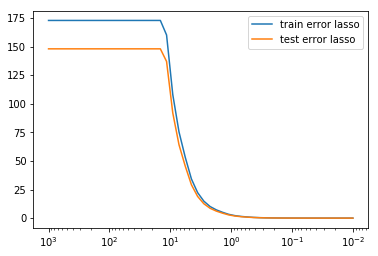

In [19]:
alphas_ = np.logspace(-2,3,base=10)
coefs = []
model = Lasso(fit_intercept=True)
mse_test = []
mse_train = []
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    yhat_train = model.predict(X_train_scaled)
    yhat_test = model.predict(X_test_scaled)
    mse_train.append(np.mean(np.power(yhat_train - y_train, 2)))
    mse_test.append(np.mean(np.power(yhat_test - y_test, 2)))
ax = plt.gca()
ax.plot(alphas_,mse_train,label='train error lasso')
ax.plot(alphas_,mse_test,label='test error lasso')
plt.legend(loc=1)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()

En el gráfico se observa un error de train y test constante entre
labda 10^3 y 10^1 para luego caer rápidamente, llegando a aproximadamente 0 en lambda 10^0

Se observa además, durante el tramo, que el error de los datos de prueba son menores que 
los errores de entrenamiento, lo que sugiere un overfitting controlado por lo que se concluye cierta habilidad de generalización por parte de la máquina.

>l) Estime el valor del parámetro de regularización en alguno de los modelos anteriores haciendo uso de la técnica validación cruzada con un número de folds igual a  𝐾=5  y  𝐾=10 . Recuerde que para que la estimación sea razonable, en cada configuración (fold) deberá reajustar los pesos del modelo. Mida el error real del modelo (ésto es sobre el conjunto de pruebas). Debido a la escala del error puede utilizar auxiliarmente MAE como métrica de desempeño. Compare y concluya.

In [20]:
yhat_test = linreg.predict(X_test_scaled)
mse_test = np.mean(np.power(yhat_test - y_test, 2))
from sklearn.model_selection import KFold
K=10
kf = KFold(n_splits=K)
mse_cv = 0
for train, val in kf.split(X_train_scaled):
    linreg = LR(fit_intercept=True, n_jobs=1)
    linreg.fit(X_train_scaled[train], y_train[train])
    yhat_kfold_val = linreg.predict(X_train_scaled[val])
    mse_fold = np.mean(np.power(yhat_kfold_val - y_train[val], 2))
    mse_cv += mse_fold
mse_cv = mse_cv / K
# ...#or MAE
mae_fold = np.mean(np.abs(yhat_kfold_val - y_train[val]))
print mae_fold

0.16910985


al comparar los errores con mae k=5 vs mae k=10
se puede apreciar que el error de k=10(0.16994166) es menor a k=5(0.17452466).
Lo anterior tiene sentido ya que la validación cruzada puede aumentar a medida
que se utilizan más grupos de pruebas para validarse entre ellos.

>m) Con el modelo que se piense que es el mejor, en base a todo lo experimentado. Realice el ranking de las universidades del que no se tienen etiquetas (unlabeled data o target data) a través de predecir los datos que se dejaron como pruebas y ordenar su score en el dataframe.

In [24]:
df_test["total_score"] = model.predict(X_test_scaled) #predict score
# ...#armar un raking
univ_chilenas = df_test[df_test["country_Chile"]==1]
rannking_univ_ch = univ_chilenas.sort_values(by="total_score",ascending=False)
ranking = 1
for index,row in rannking_univ_ch.iterrows():
    print("%d - Institucion: %s" %(ranking,row["university_name"]))
    ranking+=1

ValueError: Found input variables with inconsistent numbers of samples: [287, 954]